In [1]:
import logging
from utils import logging as lg
lg.set_logging(logging.ERROR)


from skimage.measure import block_reduce
import numpy as np

import logging



from model import base, provider, heatmap_evaluation
import matplotlib.pyplot as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


In [2]:
from utils import data_provider

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped')
}

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [5]:
def count_positive_relevance(model_obj, dataset):
    x = dataset.test2d.x
    y = dataset.test2d.y
    
    rr_inputs = np.zeros((x.shape[0], model_obj.architecture.recur))
    
    with model_obj.get_session() as sess:
        y_pred, y_pred_y_target = sess.run([model_obj.dag.y_pred, model_obj.dag.y_pred_y_target], feed_dict= {
            model_obj.dag.x: x,
            model_obj.dag.y_target: y,
            model_obj.dag.rx: rr_inputs,
            model_obj.dag.keep_prob: 1
        })
        
    relevance = np.sum(y_pred_y_target, axis=1)
    print('Positive relevance for model %s' % model_obj._.experiment_name)
    print('relevance >= 0 : %f' % (np.mean(relevance >= 0)))


# AOPC

In [6]:
def plot_aopc(network, dataset_name, seq, 
              methods=['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_deep_taylor'],
              path=None):
    data = dataset[dataset_name]
    fig = plt.figure(figsize=(20, 6))
    markers = ['o', '^', '*', 's', 'p']
    liss = ['b--', 'g--', 'k--', 'r--', 'r']
    ax = fig.add_subplot(121)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    labels = []
    last_values = []
    
    if path is None:
        path = model_path(network, dataset_name, seq)
        

    model_obj = provider.load(path)
    name = base.BaseNetwork.network_nickname(model_obj._.architecture_name)
    test_data = data.test2d.x
    y = data.test2d.y
    
    test_data = data.test2d.x[:1000, :, :]
    y = data.test2d.y[:1000, :]
    print('data shape')
    print(test_data.shape)

    count_positive_relevance(model_obj, data)

    relevances = []

    print('dataset %s' % dataset_name)
    for i, m in zip(range(len(methods)), methods):
        print('>> method %s' % m )
        relevance = heatmap_evaluation.aopc(model_obj, test_data, y, method=m, flip_function='minus_one')   

#         apoc =  apoc - apoc_random
        area = np.trapz(relevance, dx=1)
        print('area = %f' % area)

        ax.plot(relevance, liss[i], label=m)
        relevances.append(relevance)
        labels.append(m)
        last_values.append(relevance[-1])

    sorted_indices = np.argsort(-np.array(last_values))

    
    sorted_labels = np.array(labels)[sorted_indices]
    last_values = np.array(last_values)[sorted_indices]
    
    position = np.copy(last_values)

    xticks = range(0, len(relevances[0]), 4)

    plt.ylabel("Average functin value $f(x)$")
    plt.xlabel('perturbation steps')
    plt.legend()
    plt.xticks(xticks)
    plt.title('%s$_{%d}$ : %s ' % (name, seq, dataset_name))

    plt.show()

In [7]:
def plot_aopc_all_dataset( network, methods, seq ):
    for d in ['mnist', 'fashion-mnist']:
        plot_aopc(network, methods, d, seq)

## Shallow

data shape
(1000, 28, 28)
Positive relevance for model s2_network-mnist-seq-1---2017-12-31--12-58-57
relevance >= 0 : 0.995000
dataset mnist
>> method sensitivity
using minus_one flip
area = -63.857956
>> method simple_taylor
using minus_one flip
area = 94.936287
>> method guided_backprop
using minus_one flip
area = -155.009094
>> method lrp_alpha2_beta1
using minus_one flip
area = 93.492691
>> method lrp_deep_taylor
using minus_one flip
area = -91.662186


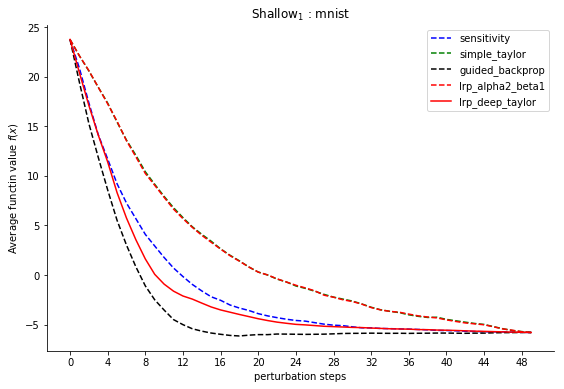

In [8]:
import imp
imp.reload(heatmap_evaluation)

plot_aopc('s2','mnist', 1)

data shape
(1000, 28, 28)
Positive relevance for model s3_network-mnist-seq-1---2017-12-31--13-46-18
relevance >= 0 : 0.999600
dataset mnist
>> method sensitivity
using minus_one flip
area = 208.060913
>> method simple_taylor
using minus_one flip
area = 244.186127
>> method guided_backprop
using minus_one flip
area = 210.884338
>> method lrp_alpha2_beta1
using minus_one flip
area = 240.564545
>> method lrp_deep_taylor
using minus_one flip
area = 216.923843


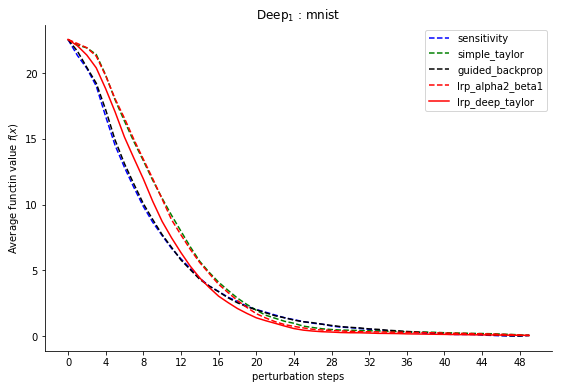

In [10]:
plot_aopc('s3', 'mnist', 1)

data shape
(1000, 28, 28)
Positive relevance for model deep_4l_network-mnist-seq-1---2017-12-31--14-27-22
relevance >= 0 : 0.996000
dataset mnist
>> method sensitivity
using minus_one flip
area = 143.235718
>> method simple_taylor
using minus_one flip
area = 180.682983
>> method guided_backprop
using minus_one flip
area = 142.789078
>> method lrp_alpha2_beta1
using minus_one flip
area = 182.007919
>> method lrp_deep_taylor
using minus_one flip
area = 163.291214


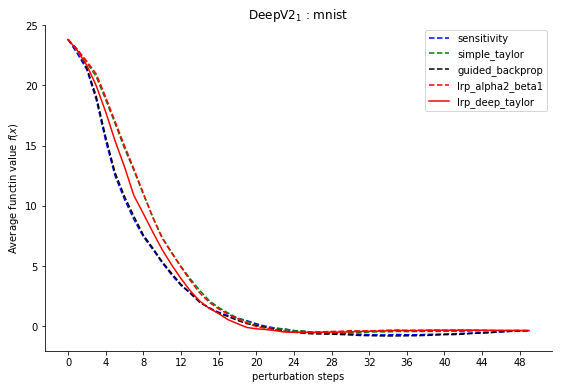

In [11]:
plot_aopc('deep_4l', 'mnist', 1)

data shape
(1000, 28, 28)
Positive relevance for model convdeep_4l_network-mnist-seq-1---2017-12-31--15-19-40
relevance >= 0 : 0.999900
dataset mnist
>> method sensitivity
using minus_one flip
area = 81.873100
>> method simple_taylor
using minus_one flip
area = 71.041878
>> method guided_backprop
using minus_one flip
area = 55.494259
>> method lrp_alpha2_beta1
using minus_one flip
area = 59.237701
>> method lrp_deep_taylor
using minus_one flip
area = 60.647667


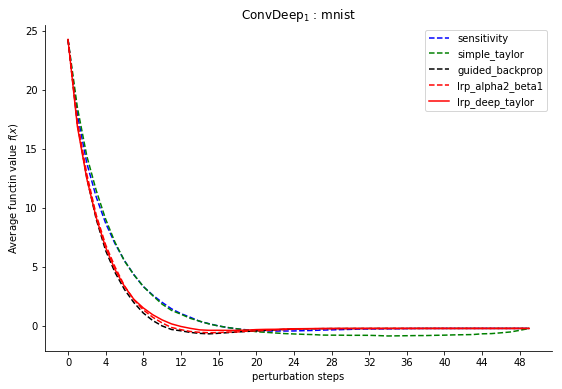

In [12]:
plot_aopc('convdeep_4l', 'mnist', 1)

data shape
(1000, 28, 28)
Positive relevance for model convdeep_4l_network-fashion-mnist-seq-1---2017-12-31--15-51-33
relevance >= 0 : 0.997000
dataset fashion-mnist
>> method sensitivity
using minus_one flip
area = 156.477341
>> method simple_taylor
using minus_one flip
area = 224.122330
>> method guided_backprop
using minus_one flip
area = 80.660126
>> method lrp_alpha2_beta1
using minus_one flip
area = 89.168053
>> method lrp_deep_taylor
using minus_one flip
area = 96.671700


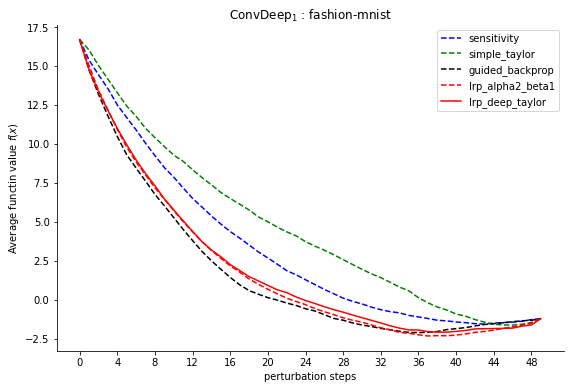

In [13]:
plot_aopc('convdeep_4l', 'fashion-mnist', 1)

(?, 11)
data shape
(1000, 28, 28)
Positive relevance for model convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-25--11-32-53
relevance >= 0 : 0.999100
dataset fashion-mnist
>> method sensitivity
using minus_one flip
area = 375.248840
>> method simple_taylor
using minus_one flip
area = 464.699219
>> method guided_backprop
using minus_one flip
(?, 11)
(?, 11)
area = 281.662170
>> method lrp_alpha2_beta1
using minus_one flip
area = 297.930817
>> method lrp_deep_taylor
using minus_one flip
area = 296.509430


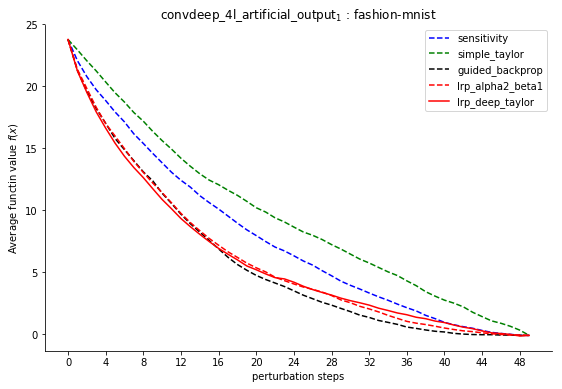

In [14]:
plot_aopc('convdeep_4l', 'fashion-mnist', 1, path="../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-1---2018-01-25--11-32-53")

(?, 11)
data shape
(1000, 28, 28)
Positive relevance for model convdeep_4l_artificial_output-fashion-mnist-seq-4---2018-01-25--12-21-03
relevance >= 0 : 0.999500
dataset fashion-mnist
>> method sensitivity
using minus_one flip
area = 277.088562
>> method simple_taylor
using minus_one flip
area = 406.976746
>> method guided_backprop
using minus_one flip
(?, 11)
(?, 11)
area = 217.189301
>> method lrp_alpha2_beta1
using minus_one flip
area = 239.536179
>> method lrp_deep_taylor
using minus_one flip
area = 266.973511


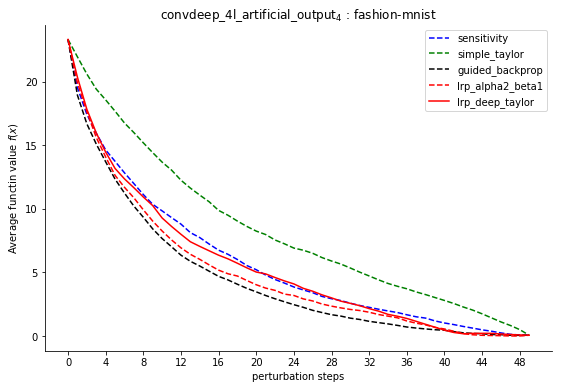

In [15]:
plot_aopc('convdeep_4l', 'fashion-mnist', 4, path="../experiment-results/aws-training/convdeep_4l_artificial_output-fashion-mnist-seq-4---2018-01-25--12-21-03")

In [ ]:
    # stats = []
    # plot_aopc_all_dataset('s2', ['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_deep_taylor'], 1)

In [ ]:
# plot_aopc_all_dataset('s2', ['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_deep_taylor'], 4)

In [ ]:
# plot_aopc_all_dataset('s2', ['sensitivity', 'simple_taylor', 'guided_backprop', 'lrp_deep_taylor'], 7)

## Deep

In [ ]:
# plot_aopc_all_dataset('s3', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 1)

In [ ]:
# plot_aopc_all_dataset('s3', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 4)

In [ ]:
# plot_aopc_all_dataset('s3', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 7)

## Deep_4l

In [ ]:
# plot_aopc_all_dataset('deep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 1)

In [ ]:
# plot_aopc_all_dataset('deep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 4)

In [ ]:
# plot_aopc_all_dataset('deep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 7)

## ConvDeep

In [ ]:
# plot_aopc_all_dataset('convdeep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 1)

In [ ]:
# plot_aopc_all_dataset('convdeep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 4)

In [ ]:
# plot_aopc_all_dataset('convdeep_4l', ['sensitivity', 'guided_backprop', 'lrp_deep_taylor'], 7)

In [ ]:
# import pandas as pd 

pd.DataFrame(stats).to_csv('aopc3.csv')

# Image Entropy

In [ ]:
# import imp
# imp.reload(heatmap_evaluation)
# def plot_image_entropies(networks, dataset_name, seq):
# #     pass
# #     data = dataset[dataset_name]
# #     fig = plt.figure()

# #     ax = fig.add_subplot(111)
# #     ax.spines['top'].set_visible(False)
# #     ax.spines['right'].set_visible(False)

# #     labels = []
# #     last_values = []
# #     print("Entropy of heatmaps from %s testing dataset" % (dataset_name))
# #     for m in networks:
# #         path = model_path(m, dataset_name, seq) s
# #         model_obj = provider.load(model_path(m, dataset_name, seq))
# #         entropy = heatmap_evaluation.image_entropy(model_obj, data.test2d.x[:5,:,:])   
# #         name = provider.network_nickname(model_obj._.architecture_name)
# #         print('%s : %f' % (name, entropy))
              
# # plot_image_entropies(['s2','s3', 'deep_4l', 'convdeep_4l'], 'mnist', 1)

In [ ]:
# plot_image_entropies(['s2','s3', 'deep_4l', 'convdeep_4l'], 'mnist', 4)

In [ ]:
# plot_image_entropies(['s2','s3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', 4)